# Load global images

In [5]:
import sys
sys.path.append('../../elpv-dataset/utils')
from elpv_reader import load_dataset
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import os
from tqdm import tqdm # for loading progress
import time
root = ""
images, probas, types = load_dataset()#root + "data/labels.csv")

labels = np.array([str(round(p*3)) + t for p,t in zip(probas, types)])


# Feature Descriptors

In [6]:
# Vlad with power norm, l2 norm, PCA whitening
from typing import *
from dataclasses import dataclass, field
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.decomposition import PCA
import numpy as np
import os
import pickle as pkl

from sklearn.model_selection import train_test_split

class KeypointDetector:
    keypoint_instance: Any
    name: str
    kwargs: Dict[str, Any]
    def compute(self, images):
        """
            Returns:
                all descriptors for each image    
        """
        self.num_descriptors = 0
        descriptors_list = [self._compute(img) for img in tqdm(images, total=len(images), desc='Extracting Key Points')]
        return descriptors_list

    def filename(self):
        name = f'{self.name}('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.kwargs.items())
        name += ')'
        return name

    def _compute(self, image):
        return self.keypoint_instance.detect(image)


class FeatureDescriptor:
    descriptor_instance: Any
    name: str
    kwargs: Dict[str, Any]


    def compute(self, images, keypoints):
        """
            Returns:
                all descriptors for each image    
        """
        assert(len(images) == len(keypoints))
        self.num_descriptors = 0
        descriptors_list = [self._compute(img, kp) for img, kp in zip(tqdm(images, total=len(images), desc='Extracting Features'), keypoints)]
        return descriptors_list
    
    def filename(self):
        name = f'{self.name}('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.kwargs.items())
        name += ')'
        return name
    
    def _compute(self, image, keypoints):
        return self.descriptor_instance.compute(image, keypoints)[1]
    
class SiftKP(KeypointDetector):
    def __init__(self, **kwargs):
        self.name = 'siftkp'
        self.keypoint_instance = cv.SIFT_create(**kwargs) 
        self.kwargs = kwargs # important for logging params 

class KazeKP(KeypointDetector):
    # thresh = 0.0001 good
    def __init__(self, **kwargs):
        self.name = 'kaze'
        self.keypoint_instance = cv.KAZE_create(**kwargs) 
        self.kwargs = kwargs

class AgastKP(KeypointDetector):
    # thresh=3 good
    def __init__(self, **kwargs):
        self.name = 'agast'
        self.keypoint_instance = cv.AgastFeatureDetector_create(**kwargs) 
        self.kwargs = kwargs  

###

class SiftFD(FeatureDescriptor):
    def __init__(self, **kwargs):
        self.name = 'siftfd'
        self.descriptor_instance = cv.SIFT_create(**kwargs)
        self.kwargs = kwargs

class SurfFD(FeatureDescriptor):
    def __init__(self, **kwargs):
        self.name = 'kaze'
        self.descriptor_instance = cv.KAZE_create(**kwargs) 
        self.kwargs = kwargs


class OrbFD(FeatureDescriptor):
    def __init__(self, **kwargs):
        self.name = 'orb'
        self.descriptor_instance = cv.ORB_create(**kwargs)
        self.kwargs = kwargs

# class VGGFD(FeatureDescriptor):
#     def __init__(self, **kwargs):
#         self.name = 'vgg'
#         self.base_model = VGG19(weights='imagenet')
#         # Chop the model off and take the feature vector
#         self.model = Model(inputs=self.base_model.input, outputs=self.base_model.get_layer('block5_conv4').output)
#         self.kwargs = kwargs

#     def _compute(self, image, keypoints):
#         """
#         Extract feature descriptors from keypoints in an image using VGG19.

#         :param image: The input image.
#         :param keypoints: A list of keypoints (x, y) in the image.
#         :param patch_size: The size of the patch to be extracted around each keypoint.
#         :return: A list of feature descriptors.
#         """
#         descriptors = []

#         for kp in keypoints:
#             x, y = kp.pt
#             size = kp.size

#             # Crop patch around keypoint
#             patch = image[int(y - size/2):int(y + size/2), int(x - size/2):int(x + size/2)]
#             # Resize patch to 224x224
#             if patch.shape[0] > 0 and patch.shape[1] > 0:
#                 patch = cv.cvtColor(patch, cv.COLOR_GRAY2RGB)
#                 patch = cv.resize(patch, (224, 224))
#                 patch = np.expand_dims(patch, axis=0)
#                 # print(patch.shape)
#                 # print(self.base_model.layers[0].input_shape)

#                 # Preprocess the patch and predict using VGG19
#                 patch = preprocess_input(patch)
#                 features = self.model.predict(patch)

#                 descriptors.append(features.flatten())

#         return descriptors


@dataclass
class DenseSampler(KeypointDetector):
    n_cells: int = 60

    def filename(self):
        name = 'dense('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.__dict__.items() if self.__dataclass_fields__[k].default != v and not k.startswith('_'))
        name += ')'
        return name

    def compute(self, images) -> List:
        """Returns list of descriptors in order of images"""
        descriptors = [self._compute(images[i]) for i in tqdm(range(len(images)), desc="Densley sampling image keypoints")]
        return descriptors
    
    def _compute(self, image):
        assert image is not None
        img_dim = image.shape[0]

        x_grid_size = img_dim / self.n_cells
        y_grid_size = img_dim / self.n_cells

        size = np.sqrt(x_grid_size * y_grid_size)

        # Calculate the centers of each grid cell as the keypoint
        centers = tuple(cv.KeyPoint(x * x_grid_size + x_grid_size / 2, y * y_grid_size + y_grid_size / 2, size)
                       for y in range(self.n_cells) for x in range(self.n_cells))

        return centers # cv.KeyPoint


class CustomPreprocessing:
    
    def filename(self) -> str:
        return self.__class__.__name__.lower() + '()'
        
    def transform(self, images: List[Any]):
        return np.stack([self._transform(i) for i in images], axis=0) 

    def _transform(self, image: Any) -> Any:
        ...

class Identity(CustomPreprocessing):
    def _transform(self, image: Any) -> Any:
        return image
    
@dataclass
class Fourier(CustomPreprocessing):
    normalize: bool = False
    kernel: Tuple[float, ...] = (1, 2, 0.0 , 2, 1)

    def filename(self):
        name = 'fourier('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.__dict__.items() if self.__dataclass_fields__[k].default != v and not k.startswith('_'))
        name += ')'
        return name

    
    def _transform(self, image: Any) -> Any:
        dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        half_image_size_x = image.shape[0]//2
        half_image_size_y = image.shape[1]//2

        # Retain the constant factor so that the resultant image has the same mean brightness
        old_constant = dft_shift[half_image_size_x,half_image_size_y].copy()


        kernel = np.array(self.kernel)
        kernel /= np.sum(kernel)
        kernel_radius = len(kernel)//2

        # Replace the vertical and horisontal with an average of it's neighbouring values.
        dft_shift[:,half_image_size_y-kernel_radius:half_image_size_y +kernel_radius + 1] = kernel[None, :, None]*dft_shift[:,half_image_size_y-kernel_radius:half_image_size_y +kernel_radius + 1]

        dft_shift[half_image_size_y-kernel_radius:half_image_size_x +kernel_radius + 1, :] = kernel[:,None, None]*dft_shift[half_image_size_y-kernel_radius:half_image_size_y +kernel_radius + 1, :]

        # recover value at zero.
        dft_shift[half_image_size_x,half_image_size_y] = old_constant

        img_back = (cv.idft(np.fft.ifftshift(dft_shift)) / (image.shape[0] * image.shape[1]))[:,:,0]


        if self.normalize:
            img_back = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX)
        else:
            # We are comfortable clipping, because what will usually happen is that
            # the loss of the strong bands will cause the values to clump more tightly around the mean.
            # So it will be uncommon for much of the image to be clipped
            img_back = np.clip(img_back, 0, 255)

        img_back = np.uint8(img_back)
        
        return img_back

@dataclass
class Histostretch(CustomPreprocessing):
    normalize: bool = False
    kernel: Tuple[float, ...] = (1, 2, 0.0 , 2, 1)

    def filename(self):
        name = 'histostretch('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.__dict__.items() if self.__dataclass_fields__[k].default != v and not k.startswith('_'))
        name += ')'
        return name

    
    def _transform(self, image: Any) -> Any:
        # Convert to uint8 (assuming your image has values in the range [0, 255])
        image_uint8 = cv.convertScaleAbs(image)

        # Apply histogram equalization
        img_back = cv.equalizeHist(image_uint8)
        
        return img_back

from scipy import ndimage
@dataclass
class Sobel(CustomPreprocessing):
    normalize: bool = False
    kernel: Tuple[float, ...] = (1, 2, 0.0 , 2, 1)

    def filename(self):
        name = 'sobel('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.__dict__.items() if self.__dataclass_fields__[k].default != v and not k.startswith('_'))
        name += ')'
        return name

    
    def _transform(self, image: Any) -> Any:
        # Convert to uint8 (assuming your image has values in the range [0, 255])
        ascent = cv.convertScaleAbs(image)
        ascent = cv.normalize(ascent, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)

        sobel_h = ndimage.sobel(ascent, 0)  # horizontal gradient
        sobel_v = ndimage.sobel(ascent, 1)  # vertical gradient
        magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
        magnitude *= 255.0 / np.max(magnitude)  # normalization
        img_back = np.uint8(magnitude)
        
        return img_back


def compute_or_cache_fd(pp: CustomPreprocessing, kp: KeypointDetector, fd: FeatureDescriptor, random_seed: int=42, amt: int = -1):
    '''
    Caches  

    kp: keypoint detector class
    fd: feature descriptor class
    random_seed: the seed with which to split test/training data. Split is automatically done with 75% test, 25% train
    amt: How much data to compute - useful for testing purposes. If left blank, it will compute for all the data.

    The guarantee is that train + test = amt if amt is less than the total data size.

    If amt is greater than the data recieved from the cache, then we will recompute to fulfill the query.
    
    '''
    
    fname = f'{kp.filename()}_{fd.filename()}_{random_seed}.pkl'
    if not isinstance(pp, Identity) or not os.path.exists(fname):
        fname = f'{pp.filename()}_{kp.filename()}_{fd.filename()}_{random_seed}.pkl'

    if amt <= 0:
        amt = len(images)
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            x_desc_train, x_desc_test, y_train, y_test, t_train, t_test = pkl.load(f) 
        if len(x_desc_train) + len(x_desc_test) >= amt:
            test_amt = amt//4
            train_amt = amt - test_amt
            x_desc_train, x_desc_test, y_train, y_test, t_train, t_test =  x_desc_train[:train_amt], x_desc_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
            return x_desc_train, x_desc_test, y_train, y_test, t_train, t_test
    # For whatever reason, we need to compute all the keypoints again.
    x_train, x_test, y_train, y_test, t_train, t_test = train_test_split(images, probas, types, test_size=0.25, random_state=random_seed, stratify=labels)

    if amt < len(images):
        test_amt = amt//4
        train_amt = amt - test_amt
        x_train, x_test, y_train, y_test, t_train, t_test = x_train[:train_amt], x_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
    x_train = pp.transform(x_train)
    x_test = pp.transform(x_test)
    x_desc_train = fd.compute(x_train, kp.compute(x_train))
    x_desc_test = fd.compute(x_test, kp.compute(x_test))
    ret = (x_desc_train, x_desc_test, y_train, y_test, t_train, t_test)
    with open(fname, 'wb') as f:
        pkl.dump(ret, f)
    return ret




# Encoding

In [21]:
from dataclasses import dataclass


@dataclass
class CustomEncoder:
    def filename(self):
        name = f'{self.__class__.__name__.lower()}('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.__dict__.items() if self.__dataclass_fields__[k].default != v and not k.startswith('_'))
        name += ')'
        return name
    
    def fit_transform(self, descriptors_list: List[Any]) -> Any:
        ...

    def fit(self, descriptors_list: List[Any]) -> Any:
        self.fit_transform(descriptors_list)

    def transform(self, descriptors_list: List[Any]) -> Any:
        ...

@dataclass
class Vlad(CustomEncoder):
    rho: float
    vlad_clusters: int = 6
    output_size: int = 1000
    pca_tol: float = 0.1
    
    _clust_model: Union[KMeans, MiniBatchKMeans] = field(init=False)
    _pca_model: PCA = field(init=False)
    _descriptor_size: int = field(init=False, default=-1)

    def __post_init__(self):
        self._clust_model = MiniBatchKMeans(n_clusters=self.vlad_clusters, random_state=0) # centers are mu_k
        self._pca_model = PCA(whiten=True, tol=0.1)
        
    def fit_transform(self, descriptors_list: List[Any]):
        all_descriptors = np.vstack([i for i in descriptors_list if i is not None]) 
        self.descriptor_size = len(all_descriptors[0])
        self._clust_model.fit(all_descriptors)
        all_vlad_vectors = []

        for descriptors in tqdm(descriptors_list, desc='Vlad.fit: Sampling all vlad_vectors'):
            all_vlad_vectors.append(self._vlad(descriptors))
        
        results = self._pca_model.fit_transform(np.array(all_vlad_vectors))
        self.output_size = min(self.output_size, self._pca_model.n_components_)
        return results[:, :self.output_size]
    
    def fit(self, images):
        self.fit_transform(images)

    def _vlad(self, descriptors):
        # 1. Each image has n descriptors of fixed size m (=128)
        # 2. Find their cluster center that each of n descriptors belongs to
        # 3. For each descriptor subtract its assigned cluster center and add it to the vlad vector for that cluster
        # vlad_vector: has k rows and m (=128) columns each row is the local aggregation of descriptors from the image

        k = self.vlad_clusters
        vlad_vector = np.zeros((k, self.descriptor_size)) # (k, 128) vector
        if descriptors is None:
            return vlad_vector.flatten()
        cluster_assignments = self._clust_model.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            vlad_vector[cluster_idx] += (descriptors[idx] - self._clust_model.cluster_centers_[cluster_idx])

        # Power normalization
        vlad_vector = (np.sign(vlad_vector) * np.abs(vlad_vector) ** self.rho).flatten()
        
        # l2 Normalization
        return vlad_vector/np.linalg.norm(vlad_vector)  # Normalize each row independently
 
    def _pca(self, vlad_vector):
        return self._pca_model.transform(vlad_vector)[:, :self.output_size]

    def transform(self, descriptors_list):    
        vecs = np.zeros((len(descriptors_list), self.descriptor_size*self.vlad_clusters))
        for i in tqdm(range(len(descriptors_list)), desc='Vlad.transform'):
            vecs[i] = self._vlad(descriptors_list[i])
        return self._pca(vecs)
    

class Vlaad(Vlad):
    def _vlad(self, descriptors):
        # 1. Each image has n descriptors of fixed size m (=128)
        # 2. Find their cluster center that each of n descriptors belongs to
        # 3. For each descriptor subtract its assigned cluster center and add it to the vlad vector for that cluster
        # vlad_vector: has k rows and m (=128) columns each row is the local aggregation of descriptors from the image

        k = self.vlad_clusters
        vlad_vector = np.zeros((k, self.descriptor_size)) # (k, 128) vector
        if descriptors is None:
            return vlad_vector.flatten()
        cluster_assignments = self._clust_model.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            residue = descriptors[idx] - self._clust_model.cluster_centers_[cluster_idx]
            vlad_vector[cluster_idx] += residue*np.linalg.norm(residue) 

        # Power normalization
        vlad_vector = (np.sign(vlad_vector) * np.abs(vlad_vector) ** self.rho).flatten()
        return vlad_vector/np.linalg.norm(vlad_vector)



def compute_or_cache_fv(enc: CustomEncoder, pp: CustomPreprocessing, kp: KeypointDetector, fd: FeatureDescriptor, random_seed: int=42, amt: int = -1):
    '''
    Caches encoder feature vectors

    enc: Encoder class
    kp: keypoint detector class
    fd: feature descriptor class
    random_seed: the seed with which to split test/training data. Split is automatically done with 75% test, 25% train
    amt: How much data to compute - useful for testing purposes. If left blank, it will compute for all the data.

    The guarantee is that train + test = amt if amt is less than the total data size.

    If amt is greater than the data recieved from the cache, then we will recompute to fulfill the query.
    
    '''
    fname = f'{enc.filename()}_{kp.filename()}_{fd.filename()}_{random_seed}.pkl'
    if not isinstance(pp, Identity) or not os.path.exists(fname):
        fname = f'{enc.filename()}_{pp.filename()}_{kp.filename()}_{fd.filename()}_{random_seed}.pkl'
    
    if amt <= 0:
        amt = len(images)    
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            x_fv_train, x_fv_test, y_train, y_test, t_train, t_test = pkl.load(f) 
        if len(x_fv_train) + len(x_fv_test) >= amt:
            test_amt = amt//4
            train_amt = amt - test_amt
            x_fv_train, x_fv_test, y_train, y_test, t_train, t_test =  x_fv_train[:train_amt], x_fv_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
            return x_fv_train, x_fv_test, y_train, y_test, t_train, t_test
    # For whatever reason, we need to compute all the keypoints again.
    x_dec_train, x_desc_test, y_train, y_test, t_train, t_test = compute_or_cache_fd(pp, kp, fd, random_seed, amt)
    if amt < len(images):
        test_amt = amt//4
        train_amt = amt - test_amt
        x_dec_train, x_desc_test, y_train, y_test, t_train, t_test = x_dec_train[:train_amt], x_desc_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
    x_fv_train = enc.fit_transform(x_dec_train)
    x_fv_test = enc.transform(x_desc_test)
    ret = (x_fv_train, x_fv_test, y_train, y_test, t_train, t_test)
    with open(fname, 'wb') as f:
        pkl.dump(ret, f)
    return ret


In [24]:


# Open a text file for writing
with open('function_runtimes.txt', 'w') as file:
    # Function 1
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Fourier(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 1: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 2
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Fourier(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 2: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 3
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Fourier(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 3: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 4
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Fourier(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 4: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 5
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Identity(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 5: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 6
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Identity(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 6: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 7
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Identity(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 7: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 8
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Identity(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 8: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 9
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Histostretch(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 9: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 10
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Histostretch(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 10: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 11
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Histostretch(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 11: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 12
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Histostretch(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 12: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 13
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Sobel(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 13: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 14
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Sobel(), KazeKP(threshold=0.0001), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 14: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 15
    start_time = time.time()
    compute_or_cache_fv(Vlad(0.5), Sobel(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 15: Time taken - {time_taken:.4f} seconds\n\n")

    # Function 16
    start_time = time.time()
    compute_or_cache_fv(Vlaad(0.5), Sobel(), AgastKP(threshold=3), SiftFD())
    time_taken = time.time() - start_time
    file.write(f"Function 16: Time taken - {time_taken:.4f} seconds\n\n")

c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
Vlad.transform: 100%|██████████| 656/656 [00:02<00:00, 323.95it/s]
c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
Vlad.transform: 100%|██████████| 656/656 [00:02<00:00, 231.41it/s]
c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarnin

In [10]:
# compute_or_cache_fv(Vlad(0.5), Fourier(),  KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Fourier(), KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlad(0.5), Fourier(),  AgastKP(threshold=3), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Fourier(), AgastKP(threshold=3), SiftFD())



(array([[-0.5650421 , -0.36286475,  1.23851596, ...,  0.86371552,
         -0.80452029, -0.51229559],
        [-0.73980236,  0.027997  ,  0.5780832 , ...,  0.43641143,
         -0.35838413,  0.43600204],
        [ 0.14530199, -1.14254814, -2.35653317, ..., -0.36866349,
         -1.75556809, -1.3372698 ],
        ...,
        [-0.83622122,  0.37435888, -1.35072632, ...,  1.14847269,
          0.43368602,  1.09770328],
        [-1.11098469,  0.18975188,  1.38995252, ...,  1.62735033,
          0.07263119,  0.2267471 ],
        [-1.27642917,  0.24204881,  0.18302785, ..., -0.8874172 ,
          1.82865341, -0.95366972]]),
 array([[-1.28873876,  0.73730084,  0.0454863 , ..., -0.27762621,
          3.61043253, -2.73319998],
        [ 0.51242246,  1.57041238, -0.02693993, ..., -6.39888467,
          2.20894796, -1.37425199],
        [-1.00398178, -0.44815974, -0.06391649, ...,  0.71567425,
         -0.85421857, -4.14530378],
        ...,
        [ 1.49941828,  0.55524898,  0.12931097, ..., -

In [23]:
# compute_or_cache_fv(Vlad(0.5), Identity(),  KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Identity(), KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlad(0.5), Identity(),  AgastKP(threshold=3), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Identity(), AgastKP(threshold=3), SiftFD())



Extracting Features: 100%|██████████| 656/656 [00:05<00:00, 120.72it/s]
c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
Vlad.transform: 100%|██████████| 656/656 [00:04<00:00, 141.46it/s]
c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
Extracting Features: 100%|██████████| 656/656 [00:19<00:00, 34.43it/s]
c:\Users\shady\anaconda3

(array([[-0.85877703,  0.25374143,  1.12304554, ...,  0.59777316,
          1.92468604, -1.34897131],
        [-0.50210816,  0.98333921,  1.00142438, ..., -1.700197  ,
         -0.29681548,  0.45280803],
        [-0.70246443,  0.82547544, -2.14623252, ..., -1.37210489,
          0.27303507,  0.76103875],
        ...,
        [-0.39828857,  0.53546305, -0.97511489, ...,  0.29363431,
         -0.72870485,  0.33544685],
        [ 0.07680611,  0.38404932,  2.1073609 , ...,  0.98900339,
          0.73822986,  0.50310838],
        [ 0.14460072,  1.55729043,  0.63680065, ..., -0.8318906 ,
          0.21439846, -0.9784188 ]]),
 array([[ 0.50908304,  1.58308151,  1.091402  , ...,  2.36620713,
          2.74071375,  0.91383812],
        [ 1.87503695,  0.19326814,  0.33467512, ...,  2.81428368,
          2.69755866,  2.39537395],
        [-0.45076606,  1.40360209,  0.30855308, ..., -2.31740766,
         -1.59872574,  4.43243353],
        ...,
        [-0.03988918, -1.48015025, -0.93401631, ...,  

In [29]:
# compute_or_cache_fv(Vlad(0.5), Histostretch(),  KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Histostretch(), KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlad(0.5), Histostretch(),  AgastKP(threshold=3), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Histostretch(), AgastKP(threshold=3), SiftFD())
























































































































































































































































































































































































































































































































































































































Extracting Key Points: 100%|██████████| 1968/1968 [01:08<00:00, 28.61it/s]






























































































































Extracting Features: 100%|██████████| 1968/1968 [00:13<00:00, 149.49it/s]


































































































































(array([[-1.09231454, -0.1178303 , -0.18827836, ...,  0.35904954,
         -1.28258974, -1.09766436],
        [-0.65950365, -1.17325457, -0.64855103, ..., -0.22945622,
          0.21481685, -0.1088785 ],
        [-0.69438863, -0.38156426,  1.61477306, ..., -0.77065878,
          0.0387685 ,  2.47689331],
        ...,
        [-0.05243063, -0.35729165, -0.81061601, ..., -0.73200833,
         -0.38952293, -0.7849394 ],
        [-0.43935063, -0.32394101, -0.62951925, ..., -2.30689019,
          1.31411566,  0.87709018],
        [-0.20036736, -1.47657611, -0.72015002, ..., -1.71170336,
          1.71871595,  0.48635784]]),
 array([[ 0.30101707, -1.48527461, -1.01730392, ...,  0.10635656,
          0.5702509 , -0.96961082],
        [ 1.7835337 , -1.18759999,  0.15357704, ...,  1.49359912,
          0.61573814, -1.94333276],
        [-0.91265993, -1.01991123,  0.5629131 , ...,  3.43943712,
          1.74383798,  0.05302531],
        ...,
        [ 0.62461022,  1.31227546, -0.87544454, ...,  

In [32]:
# compute_or_cache_fv(Vlad(0.5), Sobel(),  KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Sobel(), KazeKP(threshold=0.0001), SiftFD())
# compute_or_cache_fv(Vlad(0.5), Sobel(),  AgastKP(threshold=3), SiftFD())
# compute_or_cache_fv(Vlaad(0.5), Sobel(), AgastKP(threshold=3), SiftFD())
























































































































































































































































































































































































































































































































Extracting Key Points: 100%|██████████| 1968/1968 [01:03<00:00, 31.17it/s]





























































































































































Extracting Features: 100%|██████████| 1968/1968 [00:17<00:00, 114.22it/s]






































































































































































Extracting Key Points: 10

(array([[-0.84894801,  1.285703  , -0.03357418, ..., -0.31560665,
         -0.23921904,  0.2493352 ],
        [-0.0768516 , -1.35338544,  0.41504035, ...,  1.54201308,
          1.53561914, -0.88872371],
        [-0.53204783, -0.58294207, -1.7158036 , ..., -0.33216633,
          0.67268609, -0.0561507 ],
        ...,
        [-0.66692977, -0.09801448, -0.17615721, ..., -0.6698011 ,
         -1.09036749, -0.65748572],
        [-0.53148786, -0.45482913,  1.62533866, ...,  1.175061  ,
          0.2223418 ,  0.18119213],
        [-0.46315373, -0.04900778,  0.19361754, ..., -0.17548502,
          0.20919573, -0.88644707]]),
 array([[-0.36756524,  0.87096932, -0.33788778, ..., -1.96380509,
          0.96632942,  0.71726535],
        [ 2.0585299 ,  0.05337484, -0.20224515, ..., -0.70667301,
          0.3974873 ,  0.24573563],
        [-0.35387283, -1.27590002, -0.32803073, ..., -2.64025276,
          1.02630698, -0.2987334 ],
        ...,
        [-0.27814669,  2.26918142, -0.69124765, ...,  

# Testbench to check qualty of keypoint extractors

# Experiment: Graded SVC
Works best with 50 PCA components,
82.16 % accuracy with vlad_rho=1_agast_thresh=3_sift_clusters=6.pkl

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import os

# Function to get the next available index for a file
def get_next_index(base_filename):
    index = 0
    while os.path.exists(f"{base_filename}_{index}.txt"):
        index += 1
    return index

# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Fourier(),  KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Fourier(), KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Fourier(),  AgastKP(threshold=3), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Fourier(), AgastKP(threshold=3), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Identity(),  KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Identity(), KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Identity(),  AgastKP(threshold=3), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Identity(), AgastKP(threshold=3), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Histostretch(),  KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Histostretch(), KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Histostretch(),  AgastKP(threshold=3), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Histostretch(), AgastKP(threshold=3), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Sobel(),  KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Sobel(), KazeKP(threshold=0.0001), SiftFD())
# x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlad(0.5), Sobel(),  AgastKP(threshold=3), SiftFD())
x_fv_train, x_fv_test, y_train, y_test, _, t_test = compute_or_cache_fv(Vlaad(0.5), Sobel(), AgastKP(threshold=3), SiftFD())

class GradedSVC(BaseEstimator, ClassifierMixin):
    def __init__(self, threshspace=[1/4, 1/2, 3/4], C=1, probability=False):
        self.threshspace = threshspace
        self.C = C
        self.probability = probability
        self.clfs = []

    def fit(self, X, y, sample_weight=None):
        '''
        y is a float sequence
        X is a feature vector sequence
        '''
        self.clfs = [SVC(C=self.C, probability=self.probability) for _ in range(len(self.threshspace))]
        for clf, thresh in zip(self.clfs, self.threshspace):
            clf.fit(X, y > thresh, sample_weight=sample_weight)
        return self

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for clf in self.clfs:
            if self.probability:
                pred = clf.predict_proba(X)[:, 1]
            else:
                pred = (clf.predict(X) + 1) // 2
            y_pred += pred
        return y_pred / len(self.clfs)
    


def classification_accuracy(y_test, y_pred, t, print_report=False):
    
    # clump into 0, 1/3, 2/3, 1 based on nearest neighbour
    # The precise thresholds only matter when values are continuous
    thresh = np.array([1/6, 1/2, 5/6, 1])
    y_pred_cls = np.sum(y_pred[:, None] > thresh[None, :], axis=-1)
    y_test_cls = np.sum(y_test[:, None] > thresh[None, :], axis=-1)
    is_mono = (t == 'mono')
    if print_report:
        print(classification_report(y_test_cls, y_pred_cls, digits=4))
    return {
        'class': {
            'confusion': confusion_matrix(y_test_cls, y_pred_cls),
            'accuracy': accuracy_score(y_test_cls, y_pred_cls),
            'f1': f1_score(y_test_cls, y_pred_cls, average=None),
            'f1_av': f1_score(y_test_cls, y_pred_cls, average='weighted'),
            'mono': {
                'confusion': confusion_matrix(y_test_cls[is_mono], y_pred_cls[is_mono]),
                'accuracy': accuracy_score(y_test_cls[is_mono], y_pred_cls[is_mono]),
                'f1': f1_score(y_test_cls[is_mono], y_pred_cls[is_mono], average=None),
                'f1_av': f1_score(y_test_cls[is_mono], y_pred_cls[is_mono], average='weighted'),
            },
            'poly': {
                'confusion': confusion_matrix(y_test_cls[~is_mono], y_pred_cls[~is_mono]),
                'accuracy': accuracy_score(y_test_cls[~is_mono], y_pred_cls[~is_mono]),
                'f1': f1_score(y_test_cls[~is_mono], y_pred_cls[~is_mono], average=None),
                'f1_av': f1_score(y_test_cls[~is_mono], y_pred_cls[~is_mono], average='weighted'),
            }
        },
        'binary': {
            'confusion': confusion_matrix(y_test > 0.5, y_pred > 0.5),
            'accuracy': accuracy_score(y_test > 0.5, y_pred > 0.5),
            'f1': f1_score(y_test > 0.5, y_pred > 0.5),
            'mono': {
                'confusion': confusion_matrix(y_test[is_mono] > 0.5, y_pred[is_mono] > 0.5),
                'accuracy': accuracy_score(y_test[is_mono] > 0.5, y_pred[is_mono] > 0.5),
                'f1': f1_score(y_test[is_mono] > 0.5, y_pred[is_mono] > 0.5)
            },
            'poly': {
                'confusion': confusion_matrix(y_test[~is_mono] > 0.5, y_pred[~is_mono] > 0.5),
                'accuracy': accuracy_score(y_test[~is_mono] > 0.5, y_pred[~is_mono] > 0.5),
                'f1': f1_score(y_test[~is_mono] > 0.5, y_pred[~is_mono] > 0.5)
            }
        }
    }
    

clf = GradedSVC()

# acc = []
# f1 = []
# sc = []

sample_weight = np.where((y_train == 1), 1, np.where((y_train == 2/3), 1, 1))
x = 13
for vec_len in range(x, x+1, 1):
    # sc.append(vec_len)
    clf.fit(x_fv_train[:, :vec_len], y_train, sample_weight=sample_weight)

    y_pred = clf.predict(x_fv_test[:, :vec_len])
    print(classification_accuracy(y_test, y_pred, t_test, print_report=True))
    print(classification_report(y_test > 0.5, y_pred > 0.5, digits=4))
    # acc.append(accuracy_score(y_test > 0.5, y_pred > 0.5))
    # f1.append(f1_score(y_test > 0.5, y_pred > 0.5))

# # Determine the base filename
# base_filename = "output"
# index = get_next_index(base_filename)
# output_filename = f"{base_filename}_{index}.txt"

# # Redirect stdout to the file
# with open(output_filename, 'w') as file:
#     sys.stdout = file
#     print(classification_accuracy(y_test, y_pred, t_test, print_report=True))
#     print(classification_report(y_test > 0.5, y_pred > 0.5, digits=4))

# # Restore stdout to the console
# sys.stdout = sys.__stdout__


              precision    recall  f1-score   support

           0     0.7289    0.8488    0.7843       377
           1     0.1628    0.1892    0.1750        74
           2     0.0000    0.0000    0.0000        26
           3     0.8687    0.4804    0.6187       179

    accuracy                         0.6402       656
   macro avg     0.4401    0.3796    0.3945       656
weighted avg     0.6743    0.6402    0.6393       656

{'class': {'confusion': array([[320,  36,  13,   8],
       [ 55,  14,   3,   2],
       [ 20,   3,   0,   3],
       [ 44,  33,  16,  86]], dtype=int64), 'accuracy': 0.6402439024390244, 'f1': array([0.78431373, 0.175     , 0.        , 0.61870504]), 'f1_av': 0.6393056035802636, 'mono': {'confusion': array([[135,   8,   0,   4],
       [ 24,   4,   0,   1],
       [ 10,   2,   0,   2],
       [ 18,  10,   2,  48]], dtype=int64), 'accuracy': 0.6977611940298507, 'f1': array([0.80838323, 0.1509434 , 0.        , 0.72180451]), 'f1_av': 0.6698150958940545}, 'poly': 

In [10]:

plt.plot(sc,acc)
plt.plot(sc, f1)

NameError: name 'sc' is not defined

(<Figure size 2000x2000 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

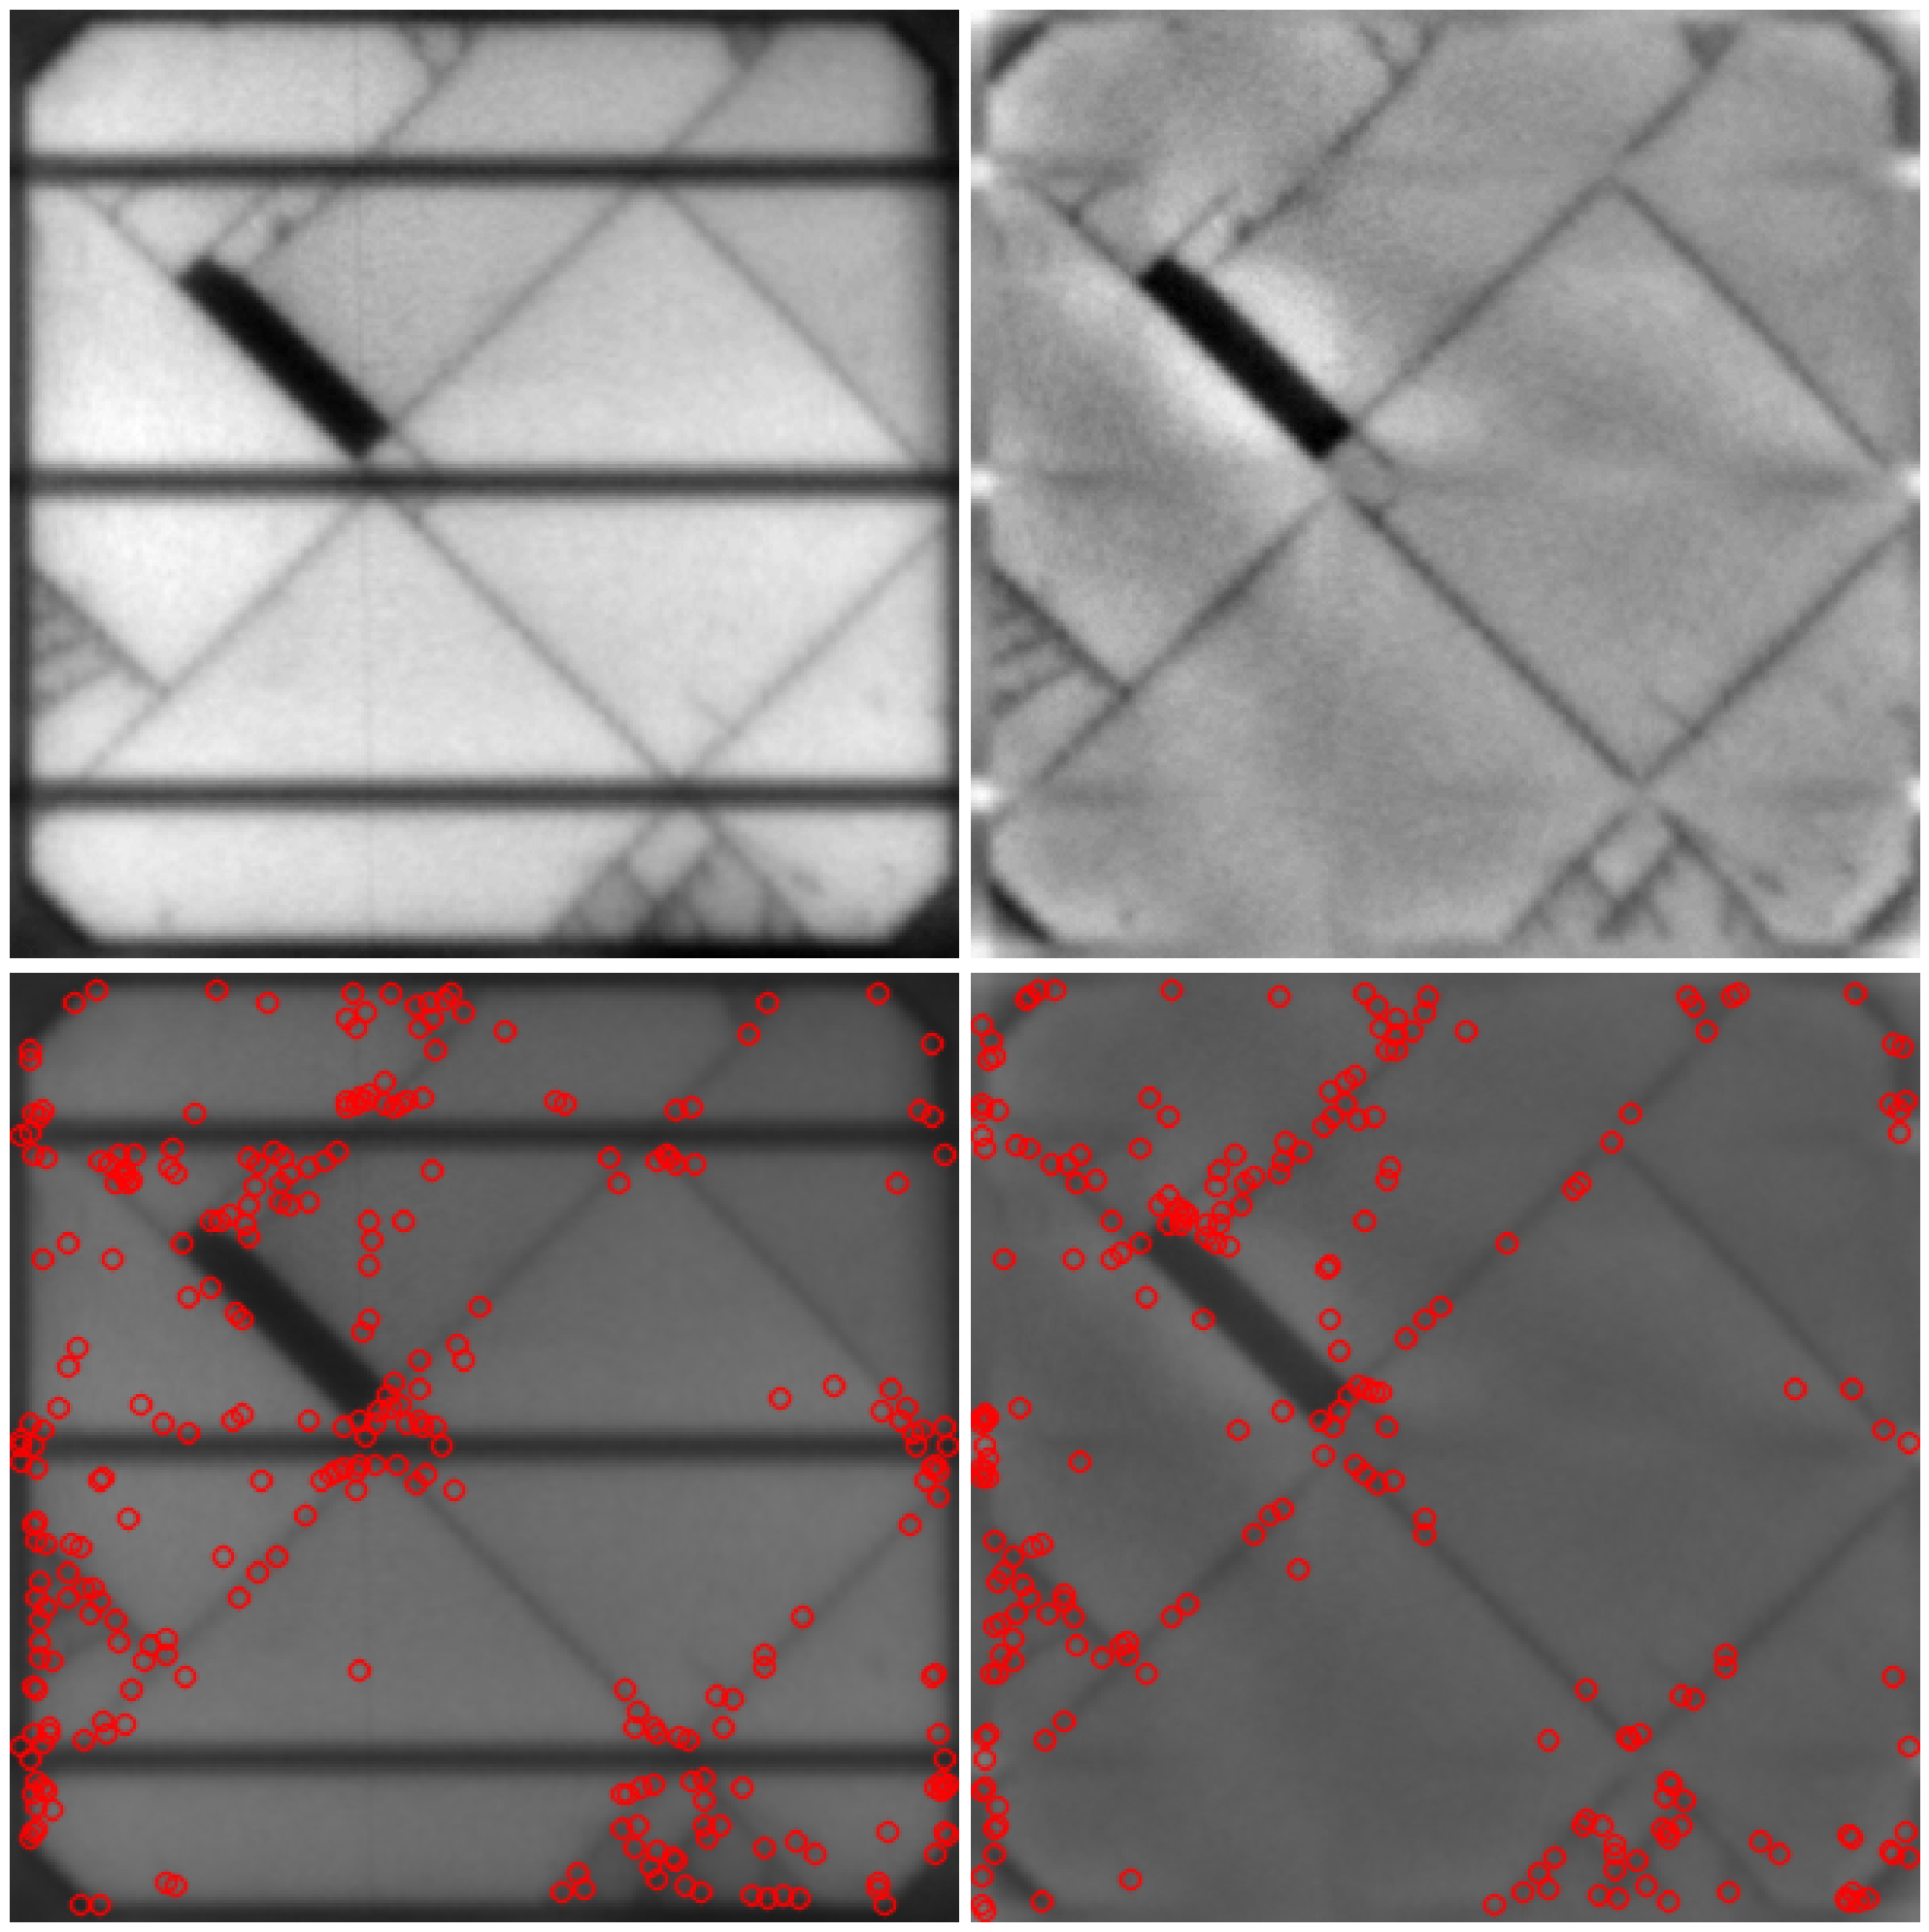

In [ ]:

from src.img import multiplot

n = 18
image = images[n]



# Normalize the result
# img_back = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX)

img_back = Fourier().transform([image])[0]


kpd = cv.AgastFeatureDetector_create(threshold=3)
# kpd = cv.KAZE_create(threshold=0.0001, upright=True)

# kpd = cv.SIFT_create()


kp = kpd.detect([img_back])
keypoint_img_back = cv.drawKeypoints(img_back, kp[0], image, color=(0, 0, 255))
kp = kpd.detect([image])
keypoint_image = cv.drawKeypoints(image, kp[0], image, color=(0, 0, 255))

multiplot(image, img_back, keypoint_image, keypoint_img_back, max_cols=2)
# # imshow(plt, np.log(np.linalg.norm(dft_shift, axis=-1))*100

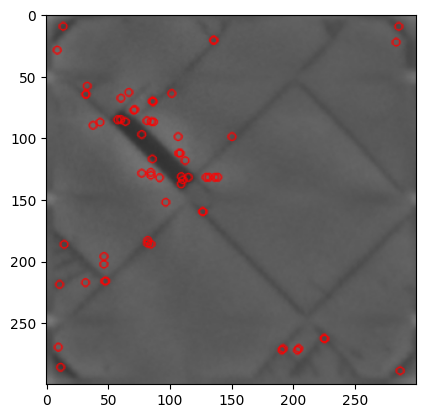

In [ ]:

import cv2
import matplotlib.pyplot as plt
from src.img import imshow
from random import sample

def make_keypoints(image):
    # Create an AGAST keypoint detector
    agast = cv2.AgastFeatureDetector_create(threshold=3)
    kaze = cv2.KAZE_create(threshold=0.0001, upright=True)

    sift = cv2.SIFT_create()

    # Detect keypoints in the image

    # kaze_kp = [kaze.detect(i) for i in images[np.random.randint(0, images.shape[0], 40)]]
    # all_kp = [j for i in kaze_kp for j in i]
    # print(len(all_kp))

    # agast_kp = [agast.detect(i) for i in images[np.random.randint(0, images.shape[0], 40)]]
    # all_kp = [j for i in agast_kp for j in i]
    # print(len(all_kp))

    # sift_kp = [sift.detect(i) for i in images[np.random.randint(0, images.shape[0], 40)]]d
    # all_kp = [j for i in sift_kp for j in i]
    # print(len(all_kp))


    # imshow('key', image)
    # kp = DenseSampler(n_cells=5).compute([image])
    kp = kaze.detect([image])
    image = cv2.drawKeypoints(image, kp[0], image, color=(0, 0, 255))
    imshow(plt, image)

make_keypoints(img_back)

# Experiment: Random Forest


In [1]:
from sklearn.ensemble import RandomForestClassifier
size = 17
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_vlad[:,:size], y_cls_train)


y_pred = clf.predict(X_test_vlad[:,:size])

# Print the classification report
print(classification_report((np.array(y_cls_test)-1)//2, (np.array(y_pred)-1)//2, digits=4))


NameError: name 'X_train_vlad' is not defined

In [9]:
from sklearn.ensemble import RandomForestClassifier
size = 17
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(x_fv_train[:,:size], y_train)


y_pred = clf.predict(x_fv_train[:,:size])

# Print the classification report
print(classification_report((np.array(y_test)-1)//2, (np.array(y_pred)-1)//2, digits=4))


ValueError: Unknown label type: 'continuous'

In [ ]:
(0.8598 + 0.6569)/2

0.7583500000000001

In [ ]:
size = 100
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report


# 0 1/6 3/6 5/6 1

threshspace = [1/4, 1/2, 3/4]

n_clfs = len(threshspace)
probability = True
clfs = [SVC(C=1, probability=probability ) for _ in range(n_clfs)]


# input(sample_weights)
        

for clf, thresh in zip(clfs, threshspace):
    clf.fit(X_train_vlad[:,:size], y_train > thresh, sample_weight=sample_weights)
    

y_pred = 0
for clf in clfs:
    # Predict on the test set
    if probability:
        pred = clf.predict_proba(X_test_vlad[:,:size])[:, 1]
    else:
        pred = (clf.predict(X_test_vlad[:,:size]) + 1)//2
    y_pred += pred

# Predicted probability
y_pred/n_clfs
 

# Print the classification report
print(classification_report((np.array(y_cls_test)-1)//2, y_pred/3 > 0.5))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       445
           1       0.73      0.56      0.64       211

    accuracy                           0.79       656
   macro avg       0.77      0.73      0.75       656
weighted avg       0.79      0.79      0.78       656



In [ ]:

 
print(y_pred.mean()/3)
# Print the classification report
print(classification_report((np.array(y_cls_test)-1)//2, (y_pred-1)/3 > 0.5))

0.6568256167742595
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       445
           1       0.75      0.46      0.57       211

    accuracy                           0.78       656
   macro avg       0.76      0.69      0.71       656
weighted avg       0.77      0.78      0.76       656



In [ ]:
# https://www.sciencedirect.com/science/article/pii/S0031320321001394


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Now we use the histograms as inputs to the SVM classifier
# (nsamples, nfeatures)

X = images
y = probas

thresholds = [0, 0.33, 0.66, 1.0]
y_classes = [sum(1 for t in thresholds if value >= t) for value in y]

X_train, X_test, y_cls_train, y_cls_test, y_train, y_test = train_test_split(X, y_classes, probas, test_size=0.25, random_state=42)

vlad = Vlad(0.5, 128, get_sift_function(), vlad_clusters=16, output_size=1000)


X_train_vlad = vlad.fit_transform(X_train)
X_test_vlad = vlad.transform(X_test)


# Initialize and train the SVM classifier
clf = LinearSVC(dual=False, max_iter=100000)
clf.fit(X_train_vlad[:,:50], y_cls_train)

# Predict on the test set
y_pred = clf.predict(X_test_vlad[:,:50])

# Print the classification report

print(classification_report(y_cls_test, y_pred))

Vlad.fit: Extracting SIFT descriptors:  14%|█▍        | 273/1968 [00:06<00:40, 42.15it/s]

KeyboardInterrupt: 

Vlad.fit: Extracting SIFT descriptors:  14%|█▍        | 273/1968 [00:21<00:40, 42.15it/s]

Vlad.fit: Extracting SIFT descriptors:   0%|          | 4/1968 [00:00<00:58, 33.69it/s]

Vlad.fit: Extracting SIFT descriptors: 100%|██████████| 1968/1968 [00:44<00:00, 43.90it/s]
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Vlad.transform: 100%|██████████| 656/656 [00:14<00:00, 45.59it/s]


In [ ]:
X_train_vlad.shape, X_test_vlad.shape

((1968, 1000), (656, 1000))

NameError: name 'LinearSVC' is not defined

In [ ]:
vlad.outp

375

In [ ]:
from keras import Sequential, Model
from keras import optimizers, losses, metrics, Input, callbacks
from keras.layers import  Dense, Dropout, Activation, Multiply, Lambda, RepeatVector, Permute
from keras import backend as K
import tensorflow as tf
from tensorflow.python.ops import state_ops as tf_state_ops


class MaskingCallback(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for m in MaskLayer.masking_vars:
            # Calculate the new length of the mask based on the epoch
            new_length = min(m.max_length, m.min_length +  ((m.max_length - m.min_length)*epoch)//m.mature_epochs)
            
            # Update the mask variable to have ones for the new_length and zeros for the rest
            new_mask = tf.concat([
                tf.ones((new_length,), dtype=tf.float32),
                tf.zeros((m.max_length - new_length,), dtype=tf.float32)
            ], axis=0)
            
            # Assign the new mask to the mask variable
            tf_state_ops.assign(m.var, new_mask)
            print(epoch, new_length)


class MaskLayer(tf.keras.layers.Layer):
    masking_vars = []
    def __init__(self, min_length, max_length, mature_epochs, **kwargs):
        super(MaskLayer, self).__init__(**kwargs)
        self.mature_epochs = mature_epochs
        self.max_length = max_length
        self.min_length = min_length
        self.masking_vars.append(self)
        self.epoch = 0
        self.var = self.add_weight(
            shape=(self.max_length,),
            name="mask",
            initializer="zeros",
            trainable=False,
        )
    
    def call(self, input):
        """call method on the layer
        Args:
            inputs (tf.Tensor): sample wise loss values for a given batch
        Returns:
            tf.Tensor (shape = ()): loss threshold value for importance sampling
        """
    
        # # Calculate the new length of the mask based on the epoch
        # self.epoch += 1
        # new_length = min(self.max_length, self.min_length +  ((self.max_length - self.min_length)*self.epoch)//self.mature_epochs)
        
        # # Update the mask variable to have ones for the new_length and zeros for the rest
        # new_mask = tf.concat([
        #     tf.ones((new_length,), dtype=tf.float32),
        #     tf.zeros((self.max_length - new_length,), dtype=tf.float32)
        # ], axis=0)
        
        # # Assign the new mask to the mask variable
        # tf_state_ops.assign(self.var, new_mask)
        # # print(self.epoch, K.sum(self.var))
        return Multiply()([input, self.var[None,:]])


def feature_attention(inputs):
    # Compute the attention scores

    
    # inputs = Multiply()([MaskingArrayCallback(20, vlad.output_size, n_epochs).var[None,:], inputs])

    attention_probs = Dense(inputs.shape[-1], activation='softmax', name='attention_probs')(inputs)

    # print(attention_probs.shape)
    attention_probs = MaskLayer(1, vlad.output_size, n_epochs)(attention_probs)
    
    # Apply the attention scores
    attention_mul = Multiply()([inputs, attention_probs])

    return attention_mul



vlad.output_size = 300
n_epochs = 10000
# Define the input layer
input_layer = Input(shape=(vlad.output_size,))  # 'd' is the number of features




# Apply the feature attention mechanism
attention_output = feature_attention(input_layer)

# # Sum up the features to create a context vector (if desired)
# context_vector = Lambda(lambda x: K.sum(x, axis=1), name='context_vector')(attention_output)


model_layers = Sequential([
    Dropout(0.5),
    Dense(20, activation='sigmoid'),
    MaskLayer(3, 20, n_epochs),
    Dropout(0.1),
    Dense(1, activation='sigmoid'),
])(attention_output)

model = Model(inputs=[input_layer], outputs=[model_layers])
def custom_accuracy(y_true, y_pred):
    # Define the discrete values as a constant tensor
    discrete_values = K.constant([0, 1/3, 2/3, 1])

    # Find the difference between predicted values and discrete values
    # y_pred will be broadcasted to match the shape of discrete_values
    diffs = K.abs(discrete_values - y_pred[:, None])

    # Find the index of the minimum difference
    min_diff_index = K.argmin(diffs, axis=-1)

    # Gather the closest discrete values to the predictions
    closest = K.gather(discrete_values, min_diff_index)

    # Compute how many are correct
    correct_predictions = K.cast(K.equal(y_true, closest), K.floatx())

    # Return the mean accuracy over the batch
    return K.mean(correct_predictions)
model.compile(optimizers.Adam(learning_rate=1e-3), loss=losses.MeanSquaredError(), metrics=[
    custom_accuracy])
res = model.fit(X_train_vlad[:, :vlad.output_size], y_train, validation_split=0.2, epochs=n_epochs, batch_size=4, callbacks=[MaskingCallback()])

0 1
0 3
Epoch 1/10000
394/394 [==============================] - 2s 4ms/step - loss: 0.1919 - custom_accuracy: 0.1104 - val_loss: 0.1885 - val_custom_accuracy: 0.1237
1 1
1 3
Epoch 2/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1904 - custom_accuracy: 0.1104 - val_loss: 0.1880 - val_custom_accuracy: 0.1237
2 1
2 3
Epoch 3/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1898 - custom_accuracy: 0.1104 - val_loss: 0.1877 - val_custom_accuracy: 0.1237
3 1
3 3
Epoch 4/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1889 - custom_accuracy: 0.1104 - val_loss: 0.1871 - val_custom_accuracy: 0.1237
4 1
4 3
Epoch 5/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1863 - custom_accuracy: 0.1110 - val_loss: 0.1860 - val_custom_accuracy: 0.1237
5 1
5 3
Epoch 6/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1844 - custom_accuracy: 0.1104 - val_loss: 0.1849 - val_custom_accuracy: 0.123

In [ ]:
MaskLayer.masking_vars[0].var

<tf.Variable 'mask:0' shape=(200,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
res

In [ ]:

for i in range(1000):
    print(model.train_on_batch(X_train_vlad, y_train, return_dict=True))

{'loss': 0.11664357781410217, 'binary_accuracy': 0.8799999952316284, 'false_negatives_7': 26.0}
{'loss': 0.12185605615377426, 'binary_accuracy': 0.871999979019165, 'false_negatives_7': 27.0}
{'loss': 0.11391579359769821, 'binary_accuracy': 0.8826666474342346, 'false_negatives_7': 20.0}
{'loss': 0.13253846764564514, 'binary_accuracy': 0.8693333268165588, 'false_negatives_7': 31.0}
{'loss': 0.12036734074354172, 'binary_accuracy': 0.8773333430290222, 'false_negatives_7': 27.0}
{'loss': 0.11787330359220505, 'binary_accuracy': 0.8826666474342346, 'false_negatives_7': 29.0}
{'loss': 0.13940924406051636, 'binary_accuracy': 0.8640000224113464, 'false_negatives_7': 28.0}
{'loss': 0.1459229290485382, 'binary_accuracy': 0.871999979019165, 'false_negatives_7': 28.0}
{'loss': 0.13336646556854248, 'binary_accuracy': 0.874666690826416, 'false_negatives_7': 29.0}
{'loss': 0.12722356617450714, 'binary_accuracy': 0.874666690826416, 'false_negatives_7': 26.0}
{'loss': 0.11397475004196167, 'binary_accurac

In [ ]:
model.tra

              precision    recall  f1-score   support

           1       0.69      0.67      0.68        36
           2       0.40      0.57      0.47         7
           3       0.00      0.00      0.00         5
           4       0.82      0.82      0.82        77

    accuracy                           0.73       125
   macro avg       0.48      0.51      0.49       125
weighted avg       0.72      0.73      0.73       125



In [ ]:
from sklearn.preprocessing import normalize

In [ ]:


def vlad(clust_model, rho, descriptor_size):
    def vlad_process(image):

        # 1. Each image has n descriptors of fixed size m (=128)
        # 2. Find their cluster center that each of n descriptors belongs to
        # 3. For each descriptor subtract its assigned cluster center and add it to the vlad vector for that cluster
        # vlad_vector: has k rows and m (=128) columns each row is the local aggregation of descriptors from the image


        k = clust_model.n_clusters
        descriptors = get_descriptors(image)
        vlad_vector = np.zeros((k, descriptor_size)) # (k, 128) vector
        if descriptors is None:
            return vlad_vector.flatten()
        cluster_assignments = kmeans.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            vlad_vector[cluster_idx] += (descriptors[idx] - kmeans.cluster_centers_[cluster_idx])

        # Power normalization
        p = 0.5
        vlad_vector = np.sign(vlad_vector) * np.abs(vlad_vector) ** p
        
        # l2 Normalization
        vlad_vector = normalize(vlad_vector, norm='l2', axis=1)  # Normalize each row independently

        vlad_vectors.append(vlad_vector.flatten())

        return vlad_vector

    return vlad_process

get_feature_vector = vlad(kmeans, 1, 128)



vlad_vectors = []
pca = PCA(whiten=True)  # You may need to set the number of components if required

# Compute VLAD vectors
for descriptors in descriptors_list:
    if descriptors is None:
        continue
    cluster_assignments = kmeans.predict(descriptors)
    vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

    for idx, cluster_idx in enumerate(cluster_assignments):
        vlad_vector[cluster_idx] += (descriptors[idx] - kmeans.cluster_centers_[cluster_idx])

    # Power normalization
    p = 0.5
    vlad_vector = np.sign(vlad_vector) * np.abs(vlad_vector) ** p
    
    # l2 Normalization
    vlad_vector = normalize(vlad_vector, norm='l2', axis=1)  # Normalize each row independently

    vlad_vectors.append(vlad_vector.flatten())

# Concatenate all VLAD vectors from all images to fit the PCA
all_vlad_vectors = np.vstack(vlad_vectors)


# PCA Whitening
all_vlad_vectors = pca.fit_transform(all_vlad_vectors)

# l2 Normalization post PCA
all_vlad_vectors = normalize(all_vlad_vectors, norm='l2', axis=1)



In [ ]:
kmeans.n_clusters

6

In [ ]:

# VLAD
vlad_vectors = []
for image in tqdm(images_small, desc='Applying vlad'):
    vlad_vectors.append(get_feature_vector(image))


In [ ]:




# VLAD
vlad_vectors_2 = []
for image in tqdm(images_small, desc='Applying vlad'):
    vlad_vectors_2.append(get_feature_vector_2(image))

Applying vlad: 100%|██████████| 2000/2000 [00:43<00:00, 45.62it/s]


In [ ]:
# RUN svm
X = np.vstack(vlad_vectors)
y = probas[:X.shape[0]]

thresholds = [0, 0.33, 0.66, 1.0]
y_classes = [sum(1 for t in thresholds if value >= t) for value in y]

X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
clf = LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.71      0.86      0.78       192
           2       0.38      0.17      0.23        30
           3       0.00      0.00      0.00        19
           4       0.66      0.64      0.65       126

    accuracy                           0.68       367
   macro avg       0.44      0.42      0.42       367
weighted avg       0.63      0.68      0.65       367



/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:


class BinaryRun():
    def __init__(self, y_test: Any, y_pred: Any, t_test: Any, thresh=0.5):
        y_test_poly = y_test[t_test == 'poly']
        y_pred_poly = y_pred[t_test == 'poly']
        y_test_mono = y_test[t_test == 'mono']
        y_pred_mono = y_pred[t_test == 'mono']

        
        
        self.mono_confusion = confusion_matrix(y_pred_mono > thresh, y_test_mono > 0.5)
        self.poly_confusion = confusion_matrix(y_pred_poly > thresh, y_test_poly > 0.5)



@dataclass
class Context():
    enc: CustomEncoder
    kp: KeypointDetector
    fd: FeatureDescriptor
    vec_len: int = 0
    model: BaseEstimator | None = None
    def name(self):
        extra_params_str = ','.join(f'{k[:3]}={v}' for k,v in self.__dict__.items() if k not in ('enc', 'kp', 'fd', 'vec_len', 'model'))
        return f'{self.enc.filename()}_{self.kp.filename()}_{self.fd.filename()}_{self.vec_len}_{self.model}_{extra_params_str}'
    def __setattr__(self, key: Any, value: Any):
        # Set any attribute dynamically
        self.__dict__[key] = value
    def __getattr__(self, key: Any):
        super().__getattribute__(key)
class Results:
    def __init__(self):
        self.results = {}
        self.contexts = {}
    def add(self, context: Context, run):
        context = copy(context)
        self.results[context.name()] = run
        self.contexts[context.name()] = context
        
    def get(self, context: Context):
        return self.contexts[context.name()]
    
    def __iter__(self):
        return iter(self.contexts.values())


working:  31%|███       | 624/2000 [00:13<00:29, 45.98it/s]


              precision    recall  f1-score   support

           1       0.78      0.74      0.76       468
           2       0.00      0.00      0.00        84
           3       0.00      0.00      0.00        11
           4       0.16      0.48      0.24        61

    accuracy                           0.60       624
   macro avg       0.24      0.30      0.25       624
weighted avg       0.60      0.60      0.59       624



/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.